
# Clustering e Regressão Linear


- Contexto: O dataset "Boston House Pricing" é um famoso dataset utilizado para construir modelos de regressão linear. Neste notebook, apresentaremos uma alternativa para criação destes modelos através de uma etapa prévia de clusterização e a posterior criação de modelos de regressão por cluster, a fim de prever a variável target MEDV
- Link para o dataset original: https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data/data
- Alunos:
  - Angelo Carmignani
  - Juan Freire Dantas Galvão
  - Vitória Karoline de Lacerda Guedes da Silva

Attribute Information
Input features in order:
- 1) CRIM: per capita crime rate by town
- 2) ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
- 3) INDUS: proportion of non-retail business acres per town
- 4) CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- 5) NOX: nitric oxides concentration (parts per 10 million) [parts/10M]
- 6) RM: average number of rooms per dwelling
- 7) AGE: proportion of owner-occupied units built prior to 1940
- 8) DIS: weighted distances to five Boston employment centres
- 9) RAD: index of accessibility to radial highways
- 10) TAX: full-value property-tax rate per $10,000 [$/10k]
- 11) PTRATIO: pupil-teacher ratio by town
- 12) B: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- 13) LSTAT: % lower status of the population

Output variable:
- 1) MEDV: Median value of owner-occupied homes in $1000's [k$]

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import silhouette_score

In [6]:
df = pd.read_csv("boston_2.csv")
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


- O objetivo inicialmente é clusterizar os dados para depois desenvolver um modelo de regressão por cluster.

In [7]:
df.isna().sum() #Não há valores ausentes

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## Clustering

### KMeans

Em um primeiro momento, aplicaremos o KMeans. Como é um algoritmo baseado na distância vetorial entre os registros, e define centróides a partir de médias, acaba sendo muito sensível a outliers. Por isso, ao usar o KMeans, é especialmente importante lidar com outliers.

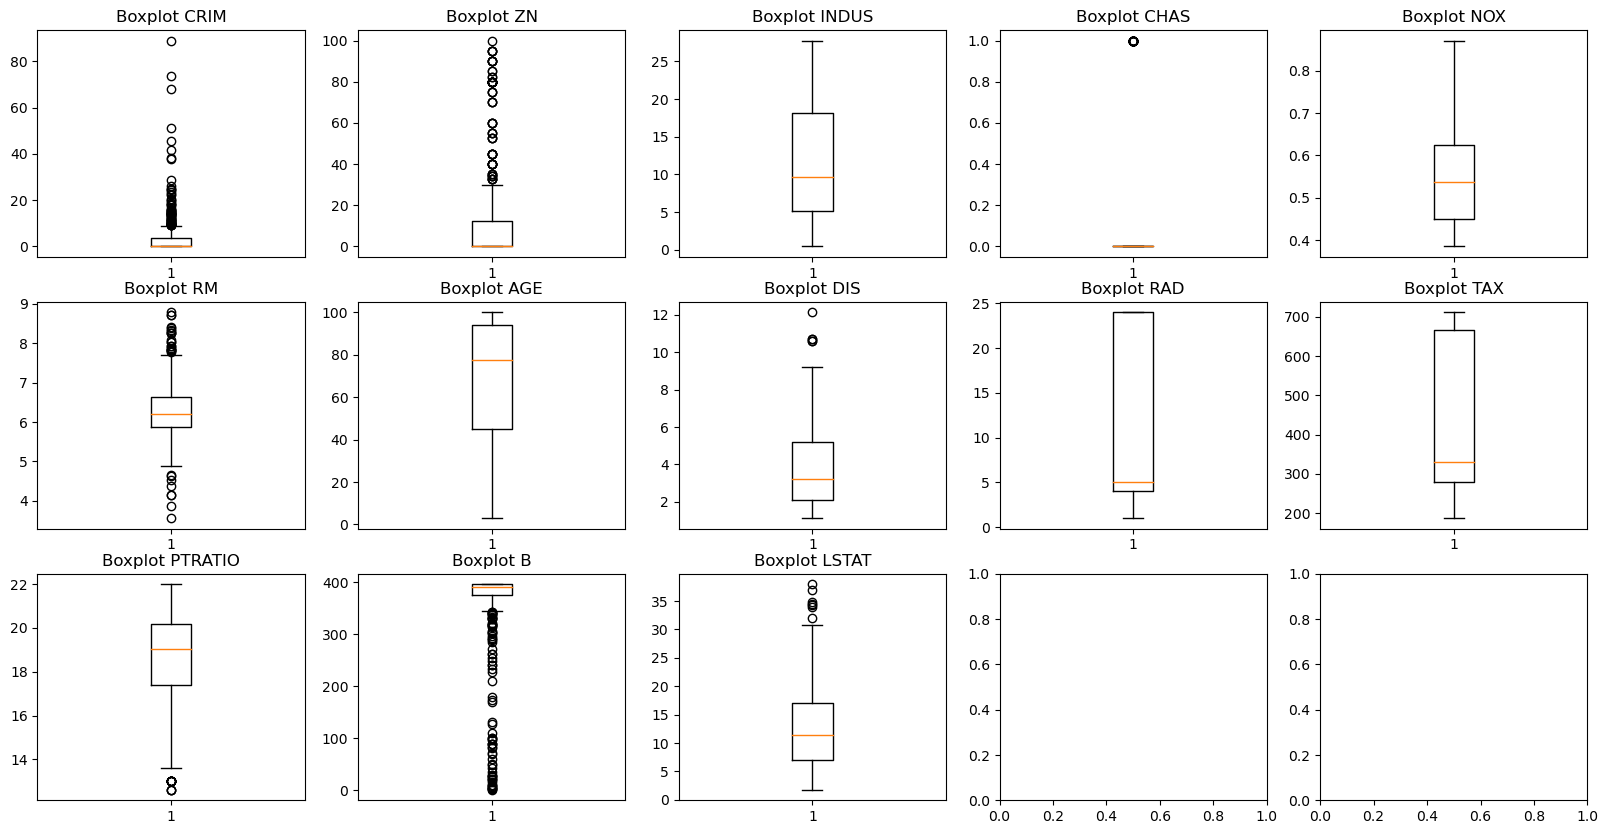

In [8]:
#Verificando outliers nas features

x = df.drop(columns = "MEDV")

fig, ax = plt.subplots(ncols=5,nrows=3,figsize = (20,10))

for index, col in enumerate(x.columns):
    row, col_idx = divmod(index, 5)  # Converte índice linear para matriz 2D
    ax[row, col_idx].boxplot(df[col])
    ax[row, col_idx].set_title(f"Boxplot {col}")

plt.show()



In [9]:
def remove_outlier(x):

  df_no = x.copy()
  for col in x.columns:

    q1 = x[col].quantile(0.25)
    q3 = x[col].quantile(0.75)

    iqr = q3 - q1

    lim_inf = q1 - 1.5*iqr
    lim_sup = q3 + 1.5*iqr

    df_no = df_no[(df_no[col]>=lim_inf) & (df_no[col]<=lim_sup)]

  return df_no

df_no = remove_outlier(x)

print(1-len(df_no)/len(x))

0.45849802371541504


- Remover os outliers tirou 45% dos dados, então ao invés de remover vamos substituir os outliers pela mediana da coluna.

In [10]:
def replace_median(x):

  df_no = x.copy()
  for col in x.columns:

    q1 = x[col].quantile(0.25)
    q3 = x[col].quantile(0.75)

    iqr = q3 - q1

    lim_inf = q1 - 1.5*iqr
    lim_sup = q3 + 1.5*iqr

    median = np.median(x[col])

    df_no[col] = np.where((df_no[col]<lim_inf) | (df_no[col]>lim_sup),median,df_no[col])

  return df_no

df_rm = replace_median(x)

- O algoritmo do KMeans se baseia na distancia entre os pontos de dados, por isso padronizar ou normalizar os dados é muito importante antes de aplicar o algoritmo.
- Utilizamos o StandardScaler, isto é, padronizamos os dados ao inves de normalizá-los. Esta decisão foi tomada em razão das features (X) serem todas uma taxa ou proporção, de forma que não estão em diferentes unidades (situação na qual é comum usar normalização).

In [11]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_rm)
df_scaled = pd.DataFrame(df_scaled, columns = x.columns)

- Feitas as tratativas podemos aplicar o algoritmo. O KMeans exige um input prévio do número de K clusters, para decidir este número K, utilizaremos o gráfico de cotovelo (Elbow).
- Esse método basicamente realiza a clusterização mudando os valores de K, e para cada valor calcula a soma dos erros quadrados dentro de cada cluster (distância de cada ponto do cluster ao centróide do cluster) - WCSS (within cluster sum of squares)
- Teremos então uma relação valor de K versus WCSS, e escolhemos o valor de K onde o WCSS é baixo e a diminuição do erro não seja mais significativa.
- Além do gráfico de Elbow, usaremos o coeficiente de silhueta para definir o valor de K.
- O coeficiente de silhueta retorna valores que variam ente -1 e 1, onde 1 o ponto está perfeitamente agrupado, -1 o ponto está mal agrupado, e 0 o ponto está na fronteira entre clusters. O cálculo é feito comparando proximidade relativa de cada ponto aos pontos do mesmo cluster (coerência interna) com os pontos do cluster mais próximo (separação externa).

Text(0, 0.5, 'Score Sill')

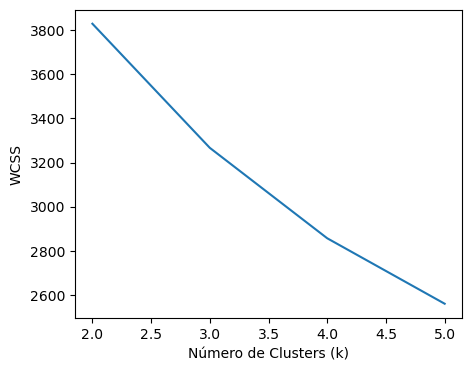

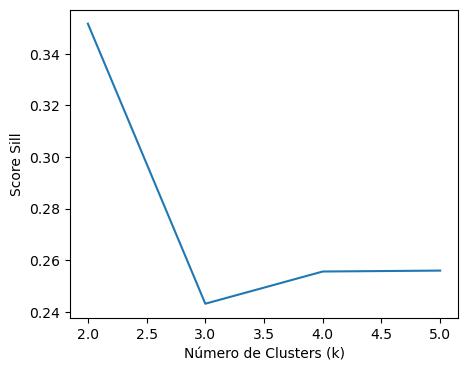

In [12]:
#Testaremos de 2 a 5 clusters

K = np.arange(2,6,1)
wcss = []
sil_score = []

for k in K:
  kmeans = KMeans(n_clusters = k, random_state = 42)
  kmeans.fit(df_scaled)
  wcss.append(kmeans.inertia_)
  score = silhouette_score(df_scaled, kmeans.labels_)
  sil_score.append(score)


plt.figure(figsize = (5,4))
plt.plot(K,wcss)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS')

plt.figure(figsize = (5,4))
plt.plot(K,sil_score)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Score Sill')

- Baseando-se nos gráficos, escolhemos o K em que tenha simultaneamente um alto Score Sill e um baixo WCSS
- k = 4

In [13]:
kmeans_end = KMeans(n_clusters = 4, random_state = 42)
kmeans_end.fit(df_scaled)
clusters_kmeans = kmeans.labels_

df_kmeans_clusters = df.copy()
df_kmeans_clusters["cluster"] = clusters_kmeans

In [14]:
df_kmeans_clusters.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,cluster
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0,3
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6,4
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7,2
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4,2
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2,2


- O dataset acima passaria então pelas etapas para construção de 4 modelos de regressão linear.

In [15]:
df_kmeans_clusters.to_csv("dataset_clusters.csv")